# K-Vector Model

# imports

In [1]:
import sys
import cv2
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../")
%matplotlib inline

%run ../../../ac/common/nps.py
%run ../../../ac/visulaizer/plotter.py
%run ../../../al/optics/parameter.py
%run ../../../al/optics/projection.py
%run ../../../al/actor/face.py
%run ../../../al/actor/screen.py
%run ../../../al/feature/face/candide.py
%run ../../../ai/predictor/eyes/optical_axis.py
%run ../../../ds/everyone/npz/profile_generator.py

Using TensorFlow backend.


In [2]:
set_np_print_precision(4)
set_np_print_non_science()

# k-error-vector  최적화

<br>

#### 1. ML로 최적 K-Error-Vector 존재 여부 확인
#### 2. 최적 근사값을 구하기 위한 최소 샘플 수 찾기

# resource paths

In [3]:
npz_path = "S:\datasets\processed\everyone-npz-profile"
candide_path="I:/_resource/archive-model/candide/candide.npz"
land_mark_path="I:/_resource/archive-model/candide/shape_predictor_68_face_landmarks.dat"
model_path = "I:/_resource/archive-model/incubator/ove/exp-home2-model.json"
weight_path = "I:/_resource/archive-model/incubator/ove/exp-home2-24e-weights.hdf5"

# imports

In [4]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation

# prepare

In [5]:
candide = Candide(candide_path, land_mark_path)

# TODO: 
# profile 00120 모바일 카메라 규격에 맞게 생성해야 함
intrinsic_param = IntrinsicParameters(1221, 1222, 598, 804)
screen = Screen(1200, 1600)
camera = Camera(4.7, intrinsic_param, screen)

opt_predictor = OpticalAxisPredictor()
opt_predictor.load_model(model_path, weight_path)
face_model = FaceModel(candide)
face = Face(camera, face_model, opt_predictor)

gen = EveryoneProfileGenerator(npz_path, face, profile_id=120)

# prepare data

In [6]:
x_train = []
y_train = []

for item, ref in gen:
    cam_x, cam_y = item.camera_x, item.camera_y
    cam_x, cam_y = 10*cam_x.astype(np.float32), -10 * cam_y.astype(np.float32)
    l_opt, r_opt = ref["l_opt"].vec(), ref["r_opt"].vec()
    l_pos, r_pos = ref["l_eye_pos"].vec(), ref["r_eye_pos"].vec()
    
    x_train.append({
        "l_opt_x": l_opt[0], 
        "l_opt_y": l_opt[1], 
        "l_opt_z": l_opt[2], 
#         "r_opt_x": r_opt[0],
#         "r_opt_y": r_opt[1],
#         "r_opt_z": r_opt[2],
    })
    
    y_train.append({
        "cam_x": cam_x, 
        "cam_y": cam_y, 
        "l_opt_x": l_opt[0], 
        "l_opt_y": l_opt[1], 
        "l_opt_z": l_opt[2], 
#         "r_opt_x": r_opt[0],
#         "r_opt_y": r_opt[1],
#         "r_opt_z": r_opt[2],
        "l_pos_x": l_pos[0], 
        "l_pos_y": l_pos[1], 
        "l_pos_z": l_pos[2], 
#         "r_pos_x": r_pos[0],
#         "r_pos_y": r_pos[1],
#         "r_pos_z": r_pos[2],
    })

In [7]:
df_x = pd.DataFrame(x_train[0:100])
df_y = pd.DataFrame(y_train[0:100])

In [8]:
#display(df_x.describe())
#display(df_y.describe())
display(df_x.head())
display(df_y.head())

,l_opt_x,l_opt_y,l_opt_z
0,0.500048,-0.143062,-0.854099
1,0.442822,-0.020348,-0.896379
2,0.647263,-0.059764,-0.759920
3,0.417290,-0.069855,-0.906085
4,0.689913,-0.028542,-0.723329


,cam_x,cam_y,l_opt_x,l_opt_y,l_opt_z,l_pos_x,l_pos_y,l_pos_z
0,33.063438,105.174627,0.500048,-0.143062,-0.854099,-220.180786,-282.522736,674.631714
1,38.215170,69.419999,0.442822,-0.020348,-0.896379,-225.941818,-286.429077,689.687378
2,-3.147584,96.502285,0.647263,-0.059764,-0.759920,-222.656677,-277.508362,672.514038
3,36.193297,103.335238,0.417290,-0.069855,-0.906085,-218.178772,-272.162598,660.213806
4,-16.935169,123.584566,0.689913,-0.028542,-0.723329,-226.192444,-248.215378,661.907654


# optimizer model

In [9]:
def project_point_mse(y_true, y_pred):
    # predicted k-error-vector
    lk_x, lk_y, lk_z = y_pred[:,0], y_pred[:,1], y_pred[:,2]
    
    # left opt-vector and 3d-eye-pos
    l_opt_x, l_opt_y, l_opt_z = y_true[:,2], y_true[:,3], y_true[:,4]
    l_pos_x, l_pos_y, l_pos_z = y_true[:,5], y_true[:,6], y_true[:,7]  
    
    # left gaze-vector
    l_gaze_x = l_opt_x + lk_x
    l_gaze_y = l_opt_y + lk_y
    l_gaze_z = l_opt_z + lk_z
    
    # left target-2d-pos
    l_k = -1 * (l_pos_z / l_gaze_z)
    l_tar_x = l_pos_x + (l_k * l_gaze_x)
    l_tar_y = l_pos_y + (l_k * l_gaze_y)
    
    l_tar_x = K.print_tensor(l_tar_x, message='target_x = ')
    l_tar_y = K.print_tensor(l_tar_y, message='target_y = ')
    
    x_cam, y_cam = y_true[:,0], y_true[:,1]
    l_loss = K.mean(K.square(x_cam-l_tar_x) + K.square(y_cam-l_tar_y), axis=None) 
    
    return l_loss

# def project_point_mse(y_true, y_pred):
#     # predicted k-error-vector
#     lk_x, lk_y, lk_z = y_true[:,0], y_true[:,1], y_true[:,2]
#     rk_x, rk_y, rk_z = y_true[:,3], y_true[:,4], y_true[:,5]
    
#     # left opt-vector and 3d-eye-pos
#     l_opt_x, l_opt_y, l_opt_z = y_pred[:,2], y_pred[:,3], y_pred[:,4]
#     l_pos_x, l_pos_y, l_pos_z = y_pred[:,5], y_pred[:,6], y_pred[:,7]
    
#     # right opt-vector and 3d-eye-pos
#     r_opt_x, r_opt_y, r_opt_z = y_pred[:,8],  y_pred[:,9],  y_pred[:,10]
#     r_pos_x, r_pos_y, r_pos_z = y_pred[:,11], y_pred[:,12], y_pred[:,13]
    
#     # left gaze-vector
#     l_gaze_x = l_opt_x + lk_x
#     l_gaze_y = l_opt_y + lk_y
#     l_gaze_z = l_opt_z + lk_z
    
#     # right gaze-vector
#     r_gaze_x = r_opt_x + rk_x
#     r_gaze_y = r_opt_y + rk_y
#     r_gaze_z = r_opt_z + rk_z
    
#     # left target-2d-pos
#     l_k = -1 * (l_pos_z / l_gaze_z)
#     l_target_x = l_pos_x + (l_k * l_gaze_x)
#     l_target_y = l_pos_y + (l_k * l_gaze_y)
    
#     # right target-2d-pos
#     r_k = -1 * (r_pos_z / r_gaze_z)
#     r_target_x = r_pos_x + (r_k * r_gaze_x)
#     r_target_y = r_pos_y + (r_k * r_gaze_y)
    
#     x_cam_in_mm, y_cam_in_mm = 10*y_pred[:,0], 10*y_pred[:,1]
    
#     l_loss = K.mean(K.square(x_cam_in_mm-l_target_x) + K.square(y_cam_in_mm - l_target_y), axis=None) 
#     r_loss = K.mean(K.square(x_cam_in_mm-r_target_x) + K.square(y_cam_in_mm - r_target_y), axis=None) 
    
#     return l_loss + r_loss

In [10]:
model = Sequential()
model.add(Dense(128, input_dim=3))
model.add(Dense(512))
model.add(Dense(8))

model.compile(optimizer='adam', loss=project_point_mse)

# optimize

In [11]:
model.fit(df_x, df_y, batch_size=1, epochs=20)

Epoch 1/20
100/100 [==============================] - 1s 11ms/step - loss: 8995.7047
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 1417.9605
Epoch 3/20
100/100 [==============================] - 1s 7ms/step - loss: 1603.4868
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 1805.3092
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 1499.6774
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 1434.2808
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 1626.4588
Epoch 8/20
100/100 [==============================] - 1s 6ms/step - loss: 1414.5624
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: 1287.6986
Epoch 10/20
100/100 [==============================] - 1s 6ms/step - loss: 1562.3963
Epoch 11/20
100/100 [==============================] - 1s 6ms/step - loss: 1335.4793
Epoch 12/20
100/100 [==============================] - 1s 6ms/step - loss

In [12]:
num_samples = 1
x = np.array(df_x.iloc[0:num_samples])
x = x.reshape((num_samples, -1))
print(x.shape)

(1, 3)


# 평균 최적 k-error-vec 계산

In [13]:
k_vecs = model.predict(x)

In [14]:
k_vecs = k_vecs[:,:6]
print(k_vecs)
k_mean_vec = np.average(k_vecs, axis=0)
print("average k-error-vector {}".format(k_mean_vec))
lk_vec, rk_vec = k_mean_vec[0:3], k_mean_vec[3:]
print("lk-vec {}, rk-vec {}".format(lk_vec, rk_vec))

lk_vec = Vector3D.from_np_vec(lk_vec)
rk_vec = Vector3D.from_np_vec(rk_vec)

[[ 1.9466  3.786  -5.7705  0.0744  0.2097  0.4508]]
average k-error-vector [ 1.9466  3.786  -5.7705  0.0744  0.2097  0.4508]
lk-vec [ 1.9466  3.786  -5.7705], rk-vec [0.0744 0.2097 0.4508]


# 검증

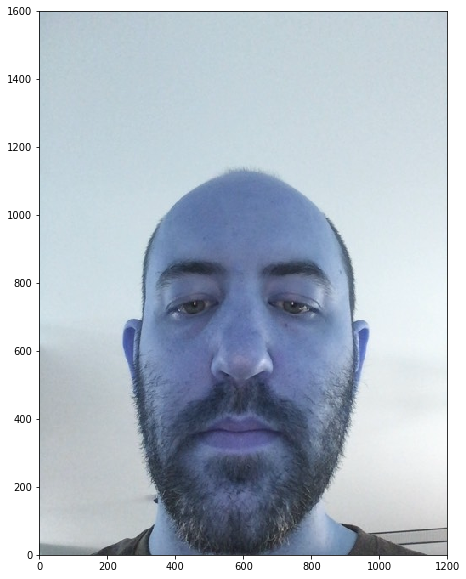

In [15]:
item = gen.items[200]
img = byte_arr_to_img(item.image_frame)
show_image(img)

In [16]:
face.match(img)
face.analysis()

In [17]:
item = y_train[200]
# int(item)

lk_x, lk_y, lk_z = lk_vec.vec()
l_opt_x, l_opt_y, l_opt_z = item["l_opt_x"], item["l_opt_y"], item["l_opt_z"]
l_pos_x, l_pos_y, l_pos_z = item["l_pos_x"], item["l_pos_y"], item["l_pos_z"] 
x_cam_in_mm, y_cam_in_mm = item["cam_x"].astype(np.float32), item["cam_y"].astype(np.float32)

l_gaze_x = l_opt_x + lk_x
l_gaze_y = l_opt_y + lk_y
l_gaze_z = l_opt_z + lk_z

l_k = -1 * (l_pos_z / l_gaze_z)
l_target_x = l_pos_x + (l_k * l_gaze_x)
l_target_y = l_pos_y + (l_k * l_gaze_y)

print("k ratio : {}".format(l_k))
print("k-vec {}".format(lk_vec.vec()))
print("opt {}, {}, {}".format(l_opt_x, l_opt_y, l_opt_z))
print("gaz {}, {}, {}".format(l_gaze_x, l_gaze_y, l_gaze_z))
print("pos {}, {}, {}".format(l_pos_x, l_pos_y, l_pos_z))

print("cam-x {}, cam-y {}".format(int(x_cam_in_mm), int(y_cam_in_mm)))
print("tar-x {}, tar-y {}".format(int(l_target_x), int(l_target_y)))

l_loss = (x_cam_in_mm-l_target_x)**2 + (y_cam_in_mm - l_target_y)**2
print(math.sqrt(l_loss))

k ratio : 103.4447021484375
k-vec [ 1.9466  3.786  -5.7705]
opt 0.6192359328269958, 0.058181919157505035, -0.7830463647842407
gaz 2.5657906532287598, 3.8441598415374756, -6.553540229797363
pos -232.22262573242188, -252.97515869140625, 677.9290161132812
cam-x -16, cam-y 123
tar-x 33, tar-y 144
54.38889831496939
